# *1. Modeling of carbon cycle*

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

In [457]:
CO2=pd.read_csv("C:\\Users\\yuanwenting\\Documents\\ESE5023\\assignment\\global.1751_2008.csv",",")
CO2

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Year,Total,Gas,Liquids,Solids,cement production,gas flaring,per capita
0,1751,3,0,0,3,0,0,NaN
1,1752,3,0,0,3,0,0,NaN
2,1753,3,0,0,3,0,0,NaN
3,1754,3,0,0,3,0,0,NaN
4,1755,3,0,0,3,0,0,NaN
...,...,...,...,...,...,...,...,...
253,2004,7782,1431,3027,2971,298,55,1.21
254,2005,8086,1473,3071,3162,320,61,1.24
255,2006,8350,1519,3080,3333,355,62,1.27
256,2007,8543,1551,3074,3468,382,68,1.28


Text(0, 0.5, 'Million Metric Tons of Carbon Per year')

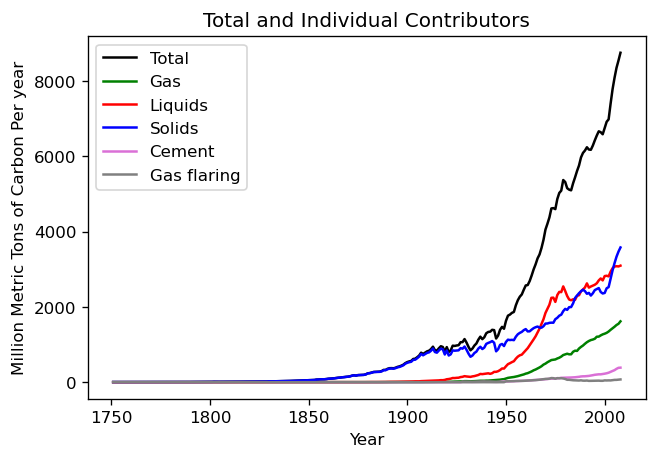

In [458]:
plt.figure(figsize=(6,4),dpi=120)
plt.plot(CO2['Year'],CO2['Total'],c='k',linestyle='-')
plt.plot(CO2['Year'],CO2['Gas'],c='g',linestyle='-')
plt.plot(CO2['Year'],CO2['Liquids'],c='r',linestyle='-')
plt.plot(CO2['Year'],CO2['Solids'],c='b',linestyle='-')
plt.plot(CO2['Year'],CO2['cement production'],c='orchid',linestyle='-')
plt.plot(CO2['Year'],CO2['gas flaring'],c='grey',linestyle='-')
plt.legend(['Total','Gas','Liquids','Solids','Cement','Gas flaring'],loc=2)

plt.title('Total and Individual Contributors')
plt.xlabel('Year');plt.ylabel('Million Metric Tons of Carbon Per year')

## *1.1 without the buffer effect*

[ 4.82316522e-18  2.43954472e-02 -1.12313831e+02]


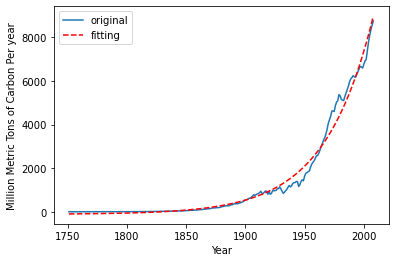

In [459]:
#首先确定排放速率r，inspired by 焦小乔同学
#进行Curve fitting，参考section 10：Optimization and fitting with scipy.optimize部分
from scipy.optimize import curve_fit

#从上面的图可以看出排放大致成指数上升，因此这里我们定义一个指数函数
#指数拟合参考https://blog.csdn.net/Dontla/article/details/104081795
def r_func(x, a, b, c):
    return a * np.exp(b * x) + c

#p0是猜测,maxfev是最大迭代次数,参考https://codebug.vip/questions-307354.htm
popt,pcov = curve_fit(r_func, CO2['Year'], CO2['Total'], p0=[1,0,1], maxfev=2000)

#popt[0]是a，popt[1]是b，popt[2]是c
y_fit= [r_func(i, popt[0], popt[1], popt[2]) for i in CO2['Year']]

#输出原曲线和拟合曲线
plt.plot(CO2['Year'], CO2['Total'],label='original')
plt.plot(CO2['Year'], y_fit,'r--',label='fitting')
plt.legend(loc=2)
plt.xlabel('Year');plt.ylabel('Million Metric Tons of Carbon Per year')

#输出参数最佳值
print(popt)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 1.0, '1987-2004 CO2 concentration without the buffer effect')

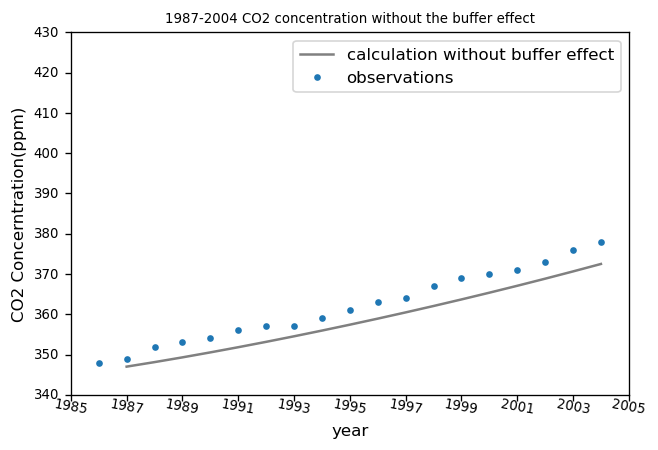

In [460]:
#排放速率r=4.82316522e-18*exp(2.43954472e-02 * x)-1.12313831e+02；r=a*e^(bx)+c,r'=a*b*e^(bx)
#scipy.integrate.odeint使用参照https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
from scipy.integrate import odeint
def pend(y,x1,k12,k21):
    N1, N2, r = y
    dydt = [-k12*N1+k21*N2+r,k12*N1-k21*N2,2.43954472e-02*(r+1.12313831e+02)]
    return dydt

#from 1987 to 2004
x1=np.arange(1987,2005)
r1=r_func(x1, 4.82316522e-18,2.43954472e-02,-1.12313831e+02)

#初始条件，来自paper,1pg=10^15g=1000百万公吨
k12=105/740;k21=102/900;N1=740*1000;N2=900*1000
y0=[N1,N2,r1[0]]
sol=odeint(pend, y0,x1, args=(k12,k21))/1000/740*347 #转化为ppm

#画根据公式1-2的积分曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(x, sol[:,0], color='gray', label='calculation without buffer effect')

#根据链接Mauna Loa CO2 annual mean data中数据画实际观测图，选取1986-2004年段数据
CO2_ppm=pd.read_csv("C:\\Users\\yuanwenting\\Documents\\ESE5023\\assignment\\co2_annmean_mlo.csv",",")
CO2_ppm_1986_2004=CO2_ppb.iloc[27:46,:]
plt.plot(CO2_ppm_1986_2004['year'],CO2_ppm_1986_2004['mean'],".",label='observations')

#设置横纵坐标轴刻度，设置legend位置，设置横纵坐标轴标签，设置标题
plt.yticks(ticks=np.arange(340,440,10), fontsize=8, rotation=0, ha='right', va='center')
plt.xticks(ticks=np.arange(1985,2006,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend(loc='best')
plt.xlabel('year');plt.ylabel('CO2 Concerntration(ppm)')
plt.title('1987-2004 CO2 concentration without the buffer effect',fontsize=8)

#相比paper中的fig.2，拟合值似乎偏低，因为我们的拟合初始值存在一定程度取小（与观测值原始数据对比发现）
#此外，排放速率从1751年开始拟合，相比直接从1987年拟合可能偏小，因此造成without buffer effect拟合曲线偏低

## *1.2 with the buffer effect*

Text(0.5, 1.0, '1987-2004 CO2 concentration with the buffer effect')

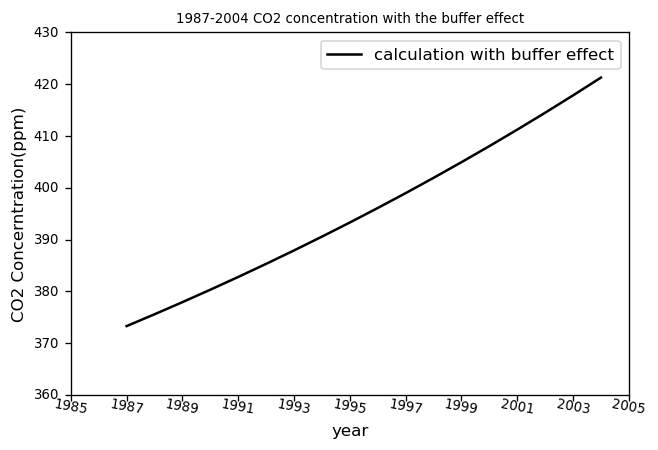

In [461]:
def pend_2(y,t2,k12,k21):
    N1,N2,r2 = y
    z = N1/1000/740*347  #z is the atmospheric CO2 concentration of ppm unit.
    N2_0 = 842*1000      #In the preindustrial era the equilibrium value of carbon in the surface ocean(842pg/yr)
    ξ = 3.69+1.86e-2*(z)-1.8e-6*(z**2)  #the buffer factor
    dydt = [-k12*N1+k21*(N2_0+ξ*(N2-N2_0))+r2, k12*N1-k21*(N2_0+ξ*(N2-N2_0)),2.43954472e-02*(r2+1.12313831e+02)]
    return dydt

#从前工业时代开始计算（1750年）
x2=np.arange(1750,2005)
r2=r_func(x2, 4.82316522e-18,2.43954472e-02,-1.12313831e+02)

#初始条件，来自paper fig.3,1pg=10^15g=1000百万公吨
k12=105/740;k21=102/900;N1=615*1000;N2=842*1000
y0=[N1,N2,r2[0]] 
sol2 = odeint(pend_2, y0, x2, args=(k12,k21))/740/1000*347 #转化为ppm

#根据公式3-4画1987-2004年的CO2浓度积分曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(x2[237:255], sol2[237:255,0], 'k', label='calculation with buffer effect')
         
#设置横纵坐标轴刻度，设置legend位置，设置横纵坐标轴标签，设置标题
plt.yticks(ticks=np.arange(360,440,10), fontsize=8, rotation=0, ha='right', va='center')
plt.xticks(ticks=np.arange(1985,2006,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend(loc='best')
plt.xlabel('year');plt.ylabel('CO2 Concerntration(ppm)')
plt.title('1987-2004 CO2 concentration with the buffer effect',fontsize=8)

In [462]:
#辅助理解
x2=np.arange(1750,2005)
x2[237:255]

array([1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004])

## *1.3 reproduce Figure 2 in Tomizuka (2009)*

Text(0.5, 1.0, '1987-2004 CO2 concentration(ppm)')

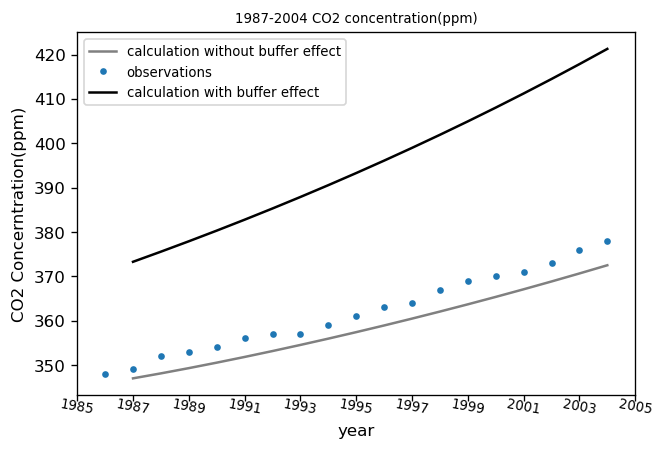

In [463]:
plt.figure(figsize=(6,4),dpi=120)

plt.plot(x, sol[:,0], color='gray', label='calculation without buffer effect')
plt.plot(CO2_ppm_1986_2004['year'],CO2_ppm_1986_2004['mean'],".",label='observations')
plt.plot(x2[237:255], sol2[237:255,0], 'k', label='calculation with buffer effect')

#设置横纵坐标轴刻度，设置legend位置，设置横纵坐标轴标签，设置标题
plt.xticks(ticks=np.arange(1985,2006,2), fontsize=8, rotation=-10, ha='center', va='center')
plt.legend(loc='best',fontsize=8)
plt.xlabel('year');plt.ylabel('CO2 Concerntration(ppm)')
plt.title('1987-2004 CO2 concentration(ppm)',fontsize=8)

## *[Bonus] reproduce Figure 4 in Tomizuka (2009)*

In [464]:
#读入Carbon Flux to the Atmosphere from Land-Use Changes 1850-2005数据再把paper中提到1750年为0.2pgc/yr的数据也加入
δ_1850_2005=pd.read_csv("C:\\Users\\yuanwenting\\Documents\\ESE5023\\assignment\\Annual Net Flux of Carbon to the Atmosphere from Land-Use Change1850-2005.csv",",")
δ_1850_2005

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


,year,Annual Net Flux/Tg
0,1750,200.0
1,1850,500.6
2,1851,492.7
3,1852,548.5
4,1853,546.8
...,...,...
152,2001,1385.4
153,2002,1517.7
154,2003,1513.2
155,2004,1534.9


[ 5.85494050e-02  5.23778758e-03 -4.58368712e+02]


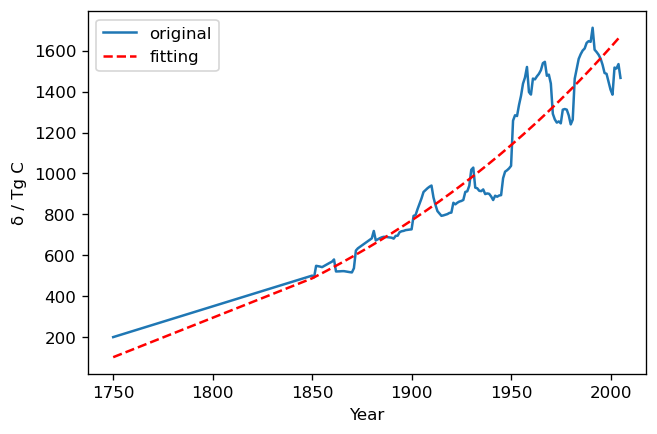

In [465]:
#利用指数函数拟合the emission rate to the atmosphere by changes in land use：δ
def δ_func(x, a, b, c):
    return a * np.exp(b * x) + c

#p0是猜测,maxfev是最大迭代次数
popt,pcov = curve_fit(δ_func, δ_1850_2000['year'], δ_1850_2000['Annual Net Flux/Tg'], p0=[0.5,0,1], maxfev=2000)

#popt[0]是a，popt[1]是b，popt[2]是c
y_fit= [δ_func(i, popt[0], popt[1], popt[2]) for i in δ_1850_2000['year']]

#输出原曲线和拟合曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(δ_1850_2000['year'], δ_1850_2000['Annual Net Flux/Tg'],label='original')
plt.plot(δ_1850_2000['year'], y_fit,'r--',label='fitting')
plt.legend(loc=2)
plt.xlabel('Year');plt.ylabel('δ / Tg C')

#输出参数最佳值
print(popt)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3369: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'CO2 concentration(ppm)')

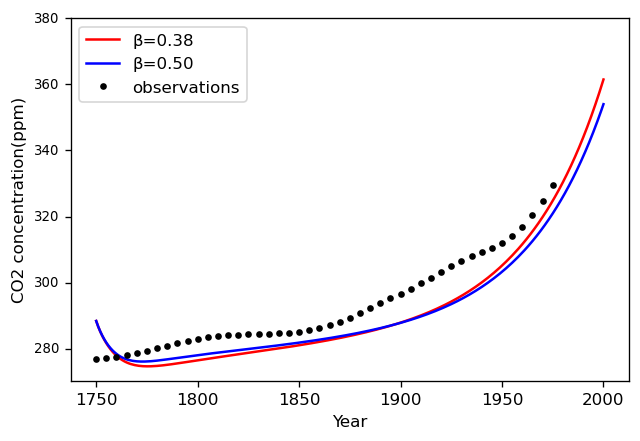

In [466]:
import math
#β=0.38
def pend_3(y,x3):
    N1,N2,N3,N4,N5,N6,N7,r3,δ = y
    z =N1/1000/740*347                    #z is the atmospheric CO2 concentration of ppm unit.
    N2_0 = 842*1000                       #In the preindustrial era the equilibrium value of carbon in the surface ocean(842pg/yr)
    p=N1; p0=615*1000; f0=62*1000         #P is the atmospheric CO2 concentration, and P0 is the preindustrial value of P
    ξ = 3.69+1.86e-2*(z)-1.8e-6*(z**2)    #the buffer factor
    f=f0*(1+0.38*math.log(p/p0,math.e))   #f is the net primary productivity
    dydt = [-60/615*N1+60/842*(N2_0+ξ*(N2-N2_0))+r3-f+δ+0.2/90000000*N5+62/1328*N7,
            60/615*N1-60/842*(N2_0+ξ*(N2-N2_0))-9/842*N2+52/9744*N3-43/842*N2,
            9/842*N2-52/9744*N3-162/9744*N3+205/26280*N4, 
            162/9744*N3-205/26280*N4+43/842*N2-0.2/26280*N4,
            0.2/26280*N4-0.2/9000000*N5,
            f-62/731*N6-2*δ,
            62/731*N6-62/1328*N7+δ,
            2.43954472e-02*(r3+1.12313831e+02),
            5.23780754e-03*(r3+4.58363315e+02)]
    return dydt

#β=0.50
def pend_3_(y,x3):
    N1,N2,N3,N4,N5,N6,N7,r3,δ = y
    z =N1/1000/740*347                  #z is the atmospheric CO2 concentration of ppm unit.
    N2_0 = 842*1000                     #In the preindustrial era the equilibrium value of carbon in the surface ocean(842pg/yr)
    p=N1; p0=615*1000; f0=62*1000       #P is the atmospheric CO2 concentration, and P0 is the preindustrial value of P
    ξ = 3.69+1.86e-2*(z)-1.8e-6*(z**2)  #the buffer factor
    f=f0*(1+0.50*math.log(p/p0,math.e)) #f is the net primary productivity
    dydt = [-60/615*N1+60/842*(N2_0+ξ*(N2-N2_0))+r3-f+δ+0.2/90000000*N5+62/1328*N7,
            60/615*N1-60/842*(N2_0+ξ*(N2-N2_0))-9/842*N2+52/9744*N3-43/842*N2,
            9/842*N2-52/9744*N3-162/9744*N3+205/26280*N4, 
            162/9744*N3-205/26280*N4+43/842*N2-0.2/26280*N4,
            0.2/26280*N4-0.2/9000000*N5,
            f-62/731*N6-2*δ,
            62/731*N6-62/1328*N7+δ,
            2.43954472e-02*(r3+1.12313831e+02),
            5.23780754e-03*(r3+4.58363315e+02)]
    return dydt

#from 1750 to 2000
x3=np.arange(1750,2001)
r3=r_func(x3,4.82316522e-18,2.43954472e-02,-1.12313831e+02)
δ=δ_func(x3,5.85469324e-02,5.23780754e-03,-4.58368712e+02)

#1750年初始值
N1=615*1000;N2=842*1000;N3=9744*1000;N4=26280*1000;N5=90000000*1000;N6=731*1000;N7=1238*1000
y0=[N1,N2,N3,N4,N5,N6,N7,r3[0],δ[0]]
sol3=odeint(pend_3, y0,x3)/1000/740*347 #转化为ppm
sol3_=odeint(pend_3_, y0,x3)/1000/740*347 #转化为ppm

#根据公式5-13画1987-2004年的CO2浓度积分曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(x3, sol3[:,0], 'r', label='β=0.38')
plt.plot(x3, sol3_[:,0], 'b', label='β=0.50')

#根据链接Historical CO2 Records from the Law Dome DE08, DE08-2, and DSS Ice Cores中数据画实观测数据图，数据截至1975年
ice_CO2=pd.read_csv("C:\\Users\\yuanwenting\\Documents\\ESE5023\\assignment\\ice core records plus smoothed data.csv",",")
plt.plot(ice_CO2['year'],ice_CO2['CO2/ppm'],"k.",label='observations')

#调y轴刻度线，调legend位置，设置横纵坐标标签
plt.yticks(ticks=np.arange(280,400,20), fontsize=8, rotation=0, ha='right', va='center')
plt.legend(loc=2)
plt.xlabel('Year');plt.ylabel('CO2 concentration(ppm)')


#对比paper中fig.4 有较大差距，
#主要是由于δ(s the emission rate to the atmosphere by changes in land use)的1850年前的原始数据找不到，
#只能用1850年后的拟合数据来表示整个1750-2000年间的δ变化，
#此外，我们使用指数拟合结果并不是很好，造成δ的较大偏差，导致1750-1850之间有一凹陷峰，
#但是我们还是能观察到变化β值(fertilization factor),对CO2年浓度无明显影响 